In [1]:
import sys                         ###noise_simulation_header###
sys.path.append('../scripts/')
from robot import *

In [2]:
from scipy.stats import uniform, norm

class RandomRobot(Robot):
    
    ###雑音が起こる確率と、起こった際の角度の標準偏差###
    def spike_noise(self,prob=0.0,angle_stderr=math.pi/60):
        if uniform.rvs() > prob:
            return 0.0
        else:
            return norm.rvs(scale=angle_stderr)
        
    def func_state_transition(self, nu, omega, time, pose):
        return super().func_state_transition(nu, omega, time, pose) \
                       + self.spike_noise(prob=0.9)

In [3]:
circling = Agent(0.2, 10.0/180*math.pi)
r= RandomRobot( np.array([0, 0, 0]).T, sensor=None, agent=circling )

r.spike_noise(prob=0.1)

3.0109193248353567e-05

<IPython.core.display.Javascript object>


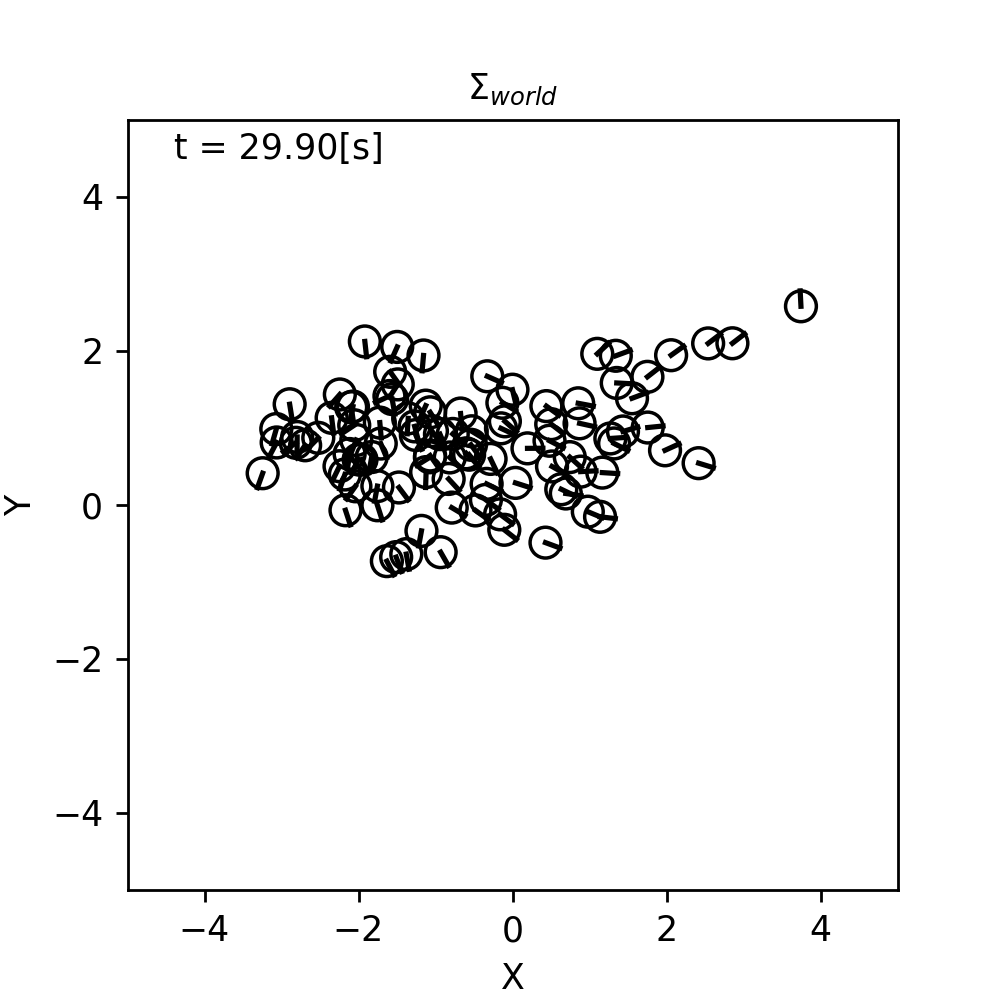

In [4]:
world = World(30, 0.1) 

for i in range(100):
    circling = Agent(0.2, 10.0/180*math.pi)
    r = RandomRobot( np.array([0, 0, 0]).T, sensor=None, agent=circling ) 
    world.append(r)

world.draw()